# Analysis of the Passenger Demographics of the Titanic

## Introduction

With [data](https://d17h27t6h515a5.cloudfront.net/topher/2016/September/57e9a84c_titanic-data/titanic-data.csv) provided from [Kaggle](https://www.kaggle.com/c/titanic/data), we can investigate information about the 891 of the passengers of the Titanic, from whether they had relatives aboard, to the fare they paid, and ultimately comparing these factors to survivorship to find any interesting relationships.  For the purpose of this analysis, we will assume the availability of the data was random (and that the convenience sampling method of collection has not harmed the usefulness of the data).

### Limitations in the Data

The data we are presented is not perfect.  As we will see below, some of the data is incomplete.  There are 891 entries in the data, but only 204 instances of fares and 714 instances of age (with some ages being estimated).  Trusting the estimations of the compilers, we still must handle missing values.  This is done first in the setup as data is added to a Pandas DataFrame object from the CSV file: Missing values are given an 'n/a' marker so that they do not interfere with later mathematical and plotting operations.

Also limiting our analysis is how the data is grouped.  It would be optimal if we were given counts for each passenger of the number of parents they had aboard, number of children they had aboard, number of siblings they had aboard, and number of spouses they had aboard.  Grouping parents and children, and spouses and siblings confuses our analysis, because the relationship between a passenger is very different if they had a child aboard versus a parent aboard, and also very different if they had a spouse aboard versus if they had a sibling aboard; especially that spouses and siblings are combined is confusing.  This conflating of relationships makes it impossible to ask questions about whether having a sibling aboard meant better survival, or being a parent meant lower survival.

### Questions Asked

The analysis starts by inquiring about passenger relationships, first by analyzing the frequency with which passengers traveled with their parents and children, and their siblings and spouses, and then by analyzing the connection between boarding location and relationships.  I hypothesize there is a positive association between number of parents and children a passenger has aboard, and the number of siblings and spouses that passenger has, because families may be more likely to travel as a complete unit.  

The remainder of the analysis concerns the connection between variables and survival. First, gender and survival are compared using a difference of proportions Z-test.  I predict women will fare better than men do to the women and children first policy in lifeboat space allocation.  Next, age and survival are compared using a Chi-squared test, with categories being age groups of 10.  I predict age will be negatively associated with survivorship, as preferential treatment may be given to the young.  Finally, because age and survivorship were found *not* to be independent, a correlation was found to predict the affect of age on survivorship. 

## Setup

We import CSV, NumPy, MatPlotLib, Seaborn, and Pandas libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

### Investigating the data

Reading the CSV to a Pandas DataFrame object, we can view summary statistics (below).


Counting the number of non-null entries in each column, we find that there were only 714 entries for age, only 204 entries for cabin, and two embarked entries were missing.  All other columns were complete:

In [2]:
# Originally, I made a dataframe from the python list version of the csv and converted some of the rows to numeric:

# pd_data = pd.DataFrame(list_data)

#   pd_data[['Age','Fare','Parch','Pclass','SibSp','Survived']] 
# = pd_data[['Age','Fare','Parch','Pclass','SibSp','Survived']].apply(pd.to_numeric)

# But a better procedure is to type the columns as they are read using pd.read():

pd_data = pd.read_csv('titanic-analysis.csv', dtype={'Survived': bool, 'Pclass': int, 'Age': float, 'SibSp': int, 'Parch': int, 'Fare': float}, na_values=['n/a'])


pd_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
pd_data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

Using Seaborn, we can give ourselves an introduction to the data by creating pairplots between variables that may be significant.  Below, we see the relationships between age, number of siblings and spouses aboard for that passenger, number of parents and children aboard for that passenger, and fare.  Each pairplot datapoint is colored according to whether the passenger ultimately survived or not.

In [4]:
newDF = pd_data[['Age','SibSp','Parch','Fare','Survived']].dropna().copy()

sns.pairplot(newDF, vars=['Age','SibSp','Parch','Fare'], hue='Survived', palette="hls")

Analyzing the pairplot, we notice a few interesting relationships.  It appears in general that the higher the number of siblings, the lower the survivorship.  Those with low age and a high number of siblings tended to suffer especially worse in terms of survival than others.    

The relationship is obvious, as expected, for fare and survival (lower fares mean lower survival).  We notice no obvious relationship, however, between fare and age, fare and number of siblings spouses, or fare and number of parents and children.  

In [5]:
# Use this to remind us of how the complete table looks
pd_data.sample(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
419,420,False,3,"Van Impe, Miss. Catharina",female,10.0,0,2,345773,24.150,NaN,S
671,672,False,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.000,B71,S
516,517,True,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.500,F33,S
567,568,False,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S
868,869,False,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.500,NaN,S


## Who Did Passengers Travel With?

From our dataset we can find information about how many siblings and spouses, and how many parents and children a titanic passenger shared the trip with.

In [6]:
print "Total Parent and Child Count: {}".format(pd_data['Parch'].sum())

Total Parent and Child Count: 340


Populating the interactive namespace from numpy and matplotlib
count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64


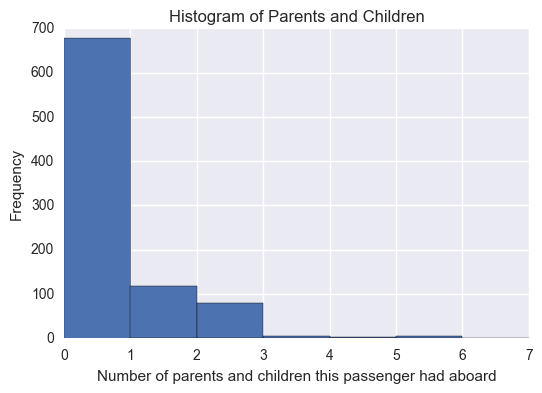

In [7]:
%pylab inline
print pd_data['Parch'].describe()
chart = pd_data['Parch'].hist(bins=range(0,8))
chart.set_xlabel("Number of parents and children this passenger had aboard")
chart.set_ylabel("Frequency")
chart.set_title("Histogram of Parents and Children")

As we see above, the vast majority of passengers do not have any siblings aboard.  The distribution is positively skewed with a mean at about 0.38

We also describe the number of siblings and spouses aboard for each passenger:

466
count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


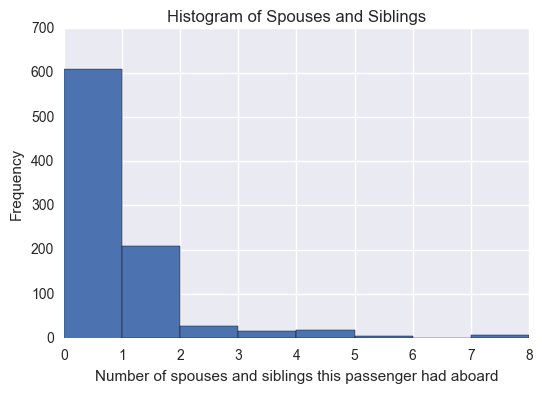

In [8]:
print pd_data['SibSp'].sum()
print pd_data['SibSp'].describe()
chart = pd_data['SibSp'].hist(bins=range(0,9))
chart.set_xlabel("Number of spouses and siblings this passenger had aboard")
chart.set_ylabel("Frequency")
chart.set_title("Histogram of Spouses and Siblings")

Passengers were slightly more likely to have a spouse or sibling aboard, with a mean number of about 0.52.  Again, the distribution is positively skewed.

I was originally interested in performing a Z-test to analyze if the two were related, but because both distributions are strongly skewed, that would not confer useful information.  We can however, analyze if there is a correlation (below, using Pearson's r):

In [9]:
# This function finds the Pearson's r for two given variables x and y
def correlation(x,y):
    stdev_x = (x-x.mean()) / x.std(ddof=0)
    stdev_y = (y-y.mean()) / y.std(ddof=0)
    
    return (stdev_x * stdev_y).mean()

# Apply to the sibling/spouse and parent/children data

correlation(pd_data['SibSp'], pd_data['Parch'])

0.41483769862015607

The correlation is moderate, which might suggest entire families (husband, mother and children) were likely to travel together, though it is not completely clear.

### Compare Relationships with Location Embarked From
Let's compare this with information about where passengers embarked from.  Below we calculate the mean number of parents and children by location embarked from, and mean number of siblings and spouses from each location.

In [10]:
print "Number of parents and children from"
print "Cherbourg: {}".format(pd_data['Parch'].loc[pd_data['Embarked'] == "C"].mean())
print "Southampton: {}".format(pd_data['Parch'].loc[pd_data['Embarked'] == "S"].mean())
print "Queensland: {}".format(pd_data['Parch'].loc[pd_data['Embarked'] == "Q"].mean())
print "--"
print "Number of Siblings and Spouses from"
print "Cherbourg: {}".format(pd_data['SibSp'].loc[pd_data['Embarked'] == "C"].mean())
print "Southampton: {}".format(pd_data['SibSp'].loc[pd_data['Embarked'] == "S"].mean())
print "Queensland: {}".format(pd_data['SibSp'].loc[pd_data['Embarked'] == "Q"].mean())

Number of parents and children from
Cherbourg: 0.363095238095
Southampton: 0.413043478261
Queensland: 0.168831168831
--
Number of Siblings and Spouses from
Cherbourg: 0.386904761905
Southampton: 0.571428571429
Queensland: 0.428571428571


These statistics are not especially surprising.  The location with the greatest number of parents and children per passenger (Southampton) was also the location with the greatest number of siblings and spouses.  What was interesting however, was that people that embarked from Queensland had twice the mean number of spouses and siblings as they did parents and children sharing the trip.

## Gender and Survival - Related?

Another interesting question to ask is if men and women experienced different survivorship levels (especially given the women and children first policy).


### Analyzing the Data

We see that there were almost double the number the number of men in the recorded data, and both samples have at least ten survivals and deaths.  The samples are independent - the survivorship of women has no impact on the survivorship of men, and vice versa.  For these reasons, we can perform a difference of proportions Z-test to determine if there was a significant difference between the proportions who survived.

Populating the interactive namespace from numpy and matplotlib
Male passengers in sample: 577
Female passengers in sample: 314


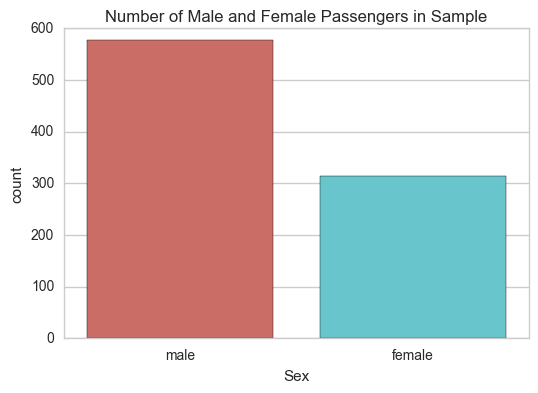

In [11]:
%pylab inline

num_men =   pd_data['Sex'].value_counts()['male']
num_women = pd_data['Sex'].value_counts()['female']

print "Male passengers in sample: {}".format(num_men)
print "Female passengers in sample: {}".format(num_women)

sns.set_style("whitegrid")
ax = sns.countplot(x="Sex", data=pd_data, palette="hls")
ax.set_title("Number of Male and Female Passengers in Sample")


In [12]:
# Survivorship by gender
pd_data.groupby('Sex').sum()['Survived']

Sex
female    233.0
male      109.0
Name: Survived, dtype: float64

For analysis in a difference of proportions Z-test, we need to convert these to proportions:

In [13]:
male_prop_survived = pd_data.groupby('Sex').sum()['Survived']['male'] / float(pd_data['Sex'].value_counts()['male'])

print male_prop_survived

0.188908145581


In [14]:
female_prop_survived = pd_data.groupby('Sex').sum()['Survived']['female'] / float(pd_data['Sex'].value_counts()['female'])

print female_prop_survived

0.742038216561


Although women were almost half as few as men in number, they accounted for double the number of survivors.  To test if this difference is significant, we will conduct a difference of proportions Z-test.  Our null hypothesis will be that the proportion of surviving men is equal to the proportion of surviving women:

$$H_0: \hat{p}_{men} = \hat{p}_{women} $$

Our alternative hypothesis will be that the proportion of surviving men is less than the proportion of surviving women:

$$H_a: \hat{p}_{men} < \hat{p}_{women} $$

We choose the one-tailed test because the lifeboat policy gives us reason to believe women would have a higher likelihood of survival, and the test offers a greater statistical power.  We will select an alpha level of 0.05 as a baseline.

To start our test, we will start by finding our critical z value:

In [15]:
import scipy.stats as st

st.norm.ppf(.05)

-1.6448536269514729

In [16]:
pooled_prop = (male_prop_survived * num_men + female_prop_survived * num_women) / (num_men + num_women)

print pooled_prop

0.383838383838


Next, we find the standard error using the pooled proportion:

In [17]:
SE = sqrt(pooled_prop * (1 - pooled_prop)) * ((1 / float(num_men)) + (1 / float(num_women)))

print SE

0.00239162874201


Finally we find our test statistic.  

In [18]:
z = (male_prop_survived - female_prop_survived) / SE

print z

-231.277564642


### Analysis of Test

Our analysis shows the z score of the difference of the proportions is 231 standard deviations below the mean (so far below that it does not register below as a percentile).  We strongly reject the null hypothesis that men and women survived at equal rates.

In [19]:
st.norm.sf(abs(z))

0.0

## Age and Death - Related?

That there was a relationship between survival and passenger class is already well known, and we established that men did suffer more deaths.  What may be more interesting is the relationship between survivorship and age.  For our analysis, we will treat estimated ages as no different than actual ages, though this may add some uncertainty to our analysis.

### Histogram of Age 

Populating the interactive namespace from numpy and matplotlib
              Age
count  714.000000
mean    29.699118
std     14.526497
min      0.420000
25%     20.125000
50%     28.000000
75%     38.000000
max     80.000000


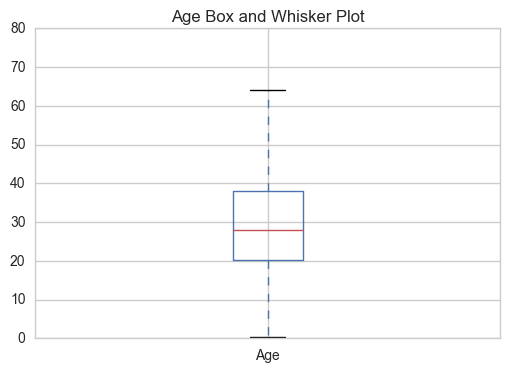

In [20]:
%pylab inline
print pd_data[['Age']].describe()
hist = pd_data[['Age']].boxplot()
hist.set_title("Age Box and Whisker Plot")

The distribution of ages is centered at just under 30 years, with a standard deviation of about 15 years.  Ages above 65 were outliers on the high end, while there were no outliers on the low end.  The higher ages make the distribution somewhat positively skewed.

Below, we take a more in depth look at age by comparing it with survival.  We see in the violin plot below that survival was better for the very young, and worse for the very old.

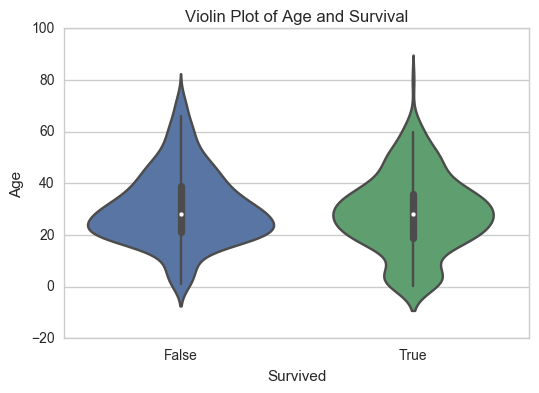

In [21]:
sns.set_style("whitegrid")
sns.plt.title("Violin Plot of Age and Survival")
ax = sns.violinplot(x=pd_data["Survived"], y=pd_data["Age"])

### Mean Survival Rate by Age

In [22]:
def bin_ages(low, high, step):
    segmented_ages = pd.cut(pd_data['Age'], bins=range(low,high,step), right=True,)

    print "Number of passengers by age range:"
    segmented_count =  segmented_ages.value_counts(sort=False)
    print segmented_count


    survived_by_age = pd_data['Age'].fillna(value=0) * pd_data['Survived']
    ages_and_survived = pd.cut(survived_by_age, bins=range(low,high,step), right=True,)

    prop_survived_by_age = ages_and_survived.value_counts() / segmented_ages.value_counts()

    print "Proportion survived by age range:"
    print prop_survived_by_age
    
    return segmented_count, prop_survived_by_age
    
first_pass = bin_ages(0,85,5)

Number of passengers by age range:
(0, 5]       44
(5, 10]      20
(10, 15]     19
(15, 20]     96
(20, 25]    122
(25, 30]    108
(30, 35]     88
(35, 40]     67
(40, 45]     47
(45, 50]     39
(50, 55]     24
(55, 60]     18
(60, 65]     14
(65, 70]      3
(70, 75]      4
(75, 80]      1
Name: Age, dtype: int64
Proportion survived by age range:
(0, 5]      0.704545
(10, 15]    0.578947
(15, 20]    0.343750
(20, 25]    0.344262
(25, 30]    0.388889
(30, 35]    0.465909
(35, 40]    0.417910
(40, 45]    0.361702
(45, 50]    0.410256
(5, 10]     0.350000
(50, 55]    0.416667
(55, 60]    0.388889
(60, 65]    0.285714
(65, 70]    0.000000
(70, 75]    0.000000
(75, 80]    1.000000
dtype: float64


Of samples with more than 20 passengers, passengers between 0 and 5 years old fared the best, with an above 70% survival rate.  For passengers over 20, survival rates improved up to about the age of 40.  But it is difficult to analyze survival for the oldest passengers: from 55-80, as their sample sizes came in under 20.  Changing the range below to count all passengers from 55-90 as a single cohort, we find their mean survival was quite low, at just 30%:

In [23]:
pass_2 = bin_ages(55,85,25)


Number of passengers by age range:
(55, 80]    40
Name: Age, dtype: int64
Proportion survived by age range:
(55, 80]    0.3
dtype: float64


### Significance Test on Age

We will use a Chi Squared test to determine if age was a significant predictor of survivorship.  We create our hypotheses:

Null Hypothesis: Age and survivorship are independent.

Alternative Hypothesis: Age and survivorship are not independent.


We will use a typical alpha level of 0.05.  With 7 degrees of freedom (8 categories minus 1), our critical value comes out to 2.167.

For age to be independent of survivorship, we would expect the distribution of survivorship amongst age categories to be uniform, close to the mean survivorship:

In [24]:
mean_survival = pd_data['Survived'].mean()
print mean_survival

0.383838383838


Next, we need to split age into useful categories.  Because our earlier cut resulted in bins with counts fewer than 5, it would not be useful for a Chi Squared test.  We therefore double the size of the bins, fulfilling the bin count greater than 4 condition:

In [25]:
pass_3 = bin_ages(0,90,10)

Number of passengers by age range:
(0, 10]      64
(10, 20]    115
(20, 30]    230
(30, 40]    155
(40, 50]     86
(50, 60]     42
(60, 70]     17
(70, 80]      5
Name: Age, dtype: int64
Proportion survived by age range:
(0, 10]     0.593750
(10, 20]    0.382609
(20, 30]    0.365217
(30, 40]    0.445161
(40, 50]    0.383721
(50, 60]    0.404762
(60, 70]    0.235294
(70, 80]    0.200000
dtype: float64


Next, we calculate the expected counts for each category:

In [26]:
expected_counts = pass_3[0] * mean_survival
print expected_counts

(0, 10]     24.565657
(10, 20]    44.141414
(20, 30]    88.282828
(30, 40]    59.494949
(40, 50]    33.010101
(50, 60]    16.121212
(60, 70]     6.525253
(70, 80]     1.919192
Name: Age, dtype: float64


Finally, we calculate our Chi Squared statistic:

In [27]:
diff = pass_3[0] * pass_3[1] - expected_counts
chi_squared = ((diff*diff)/expected_counts).sum()

print chi_squared

10.5390959004


Because our Chi Squared statistic is much greater than our critical value, we reject the null hypothesis and find that age and survivorship are not independent.

### The Correlation Between Age and Survival

Knowing that age and survival are not independent, it makes sense to find a correlation between the two.

In [28]:
# Find the correlation between age and survival

r = correlation(pd_data['Survived'], pd_data['Age'])
print "Correlation: {}".format(r)


# Find the slope of the curve
def slope(r,x,y):
    
    return (r * y.std(ddof=0)) / x.std(ddof=0)

age_slope = slope(r,pd_data['Age'],pd_data['Survived'])

print "Age Slope: {}".format(age_slope)

Correlation: -0.0779826784139
Age Slope: -0.00261254091706


Interpreting our age slope, we see that for every year older a passenger was, their predicted chance of survival would go down by just more than 0.2%.  Age was somewhat predictive of survival.

## Conclusions

We investigated a broad range of questions in a short amount of time.  We found that there was some relationship between the number of parents and children a passenger had aboard, and the number of siblings and spouses they had aboard.  The relationship between these two, and location embarked, however, was not so clear.  We then moved on to the more significant question of how variables affected survival.  We firmly rejected the hypothesis that men and women survived at equal rates (women's survivorship was much greater).  We also found that age was not independent of survivorship, and proceded to find the slope of decreased survivorship from a marginal year of age.

### Limitations

The credence we give to the conclusions above are limited mostly by the data itself.  First, passengers embarked with family members that were not accounted for in the data such as neices, nephews and fiances.  Second, in this analysis there is a heavy dependence on the age data.  But some values are missing.  If there were a pattern to the ages of the pasengers with missing ages other than that of the rest of the passengers, our analysis could be misleading.  Finally, as with all statistical analysis, we must be sure to remember correlation is not causation, and a result beyond the critical alpha level can always be due to random chance.


### Further Investigation

The analysis here was not intended to be complete, and opens up further questions to consider with the data provided.  First, because age and gender were found not to be independent of survivorship, more needs to be explored to add conclusivity to the analysis, specificly whether there is a lurking variable that can be found within the data that explain the relationships.  For example, did passengers on higher decks (nearer the lifeboats) tend to be younger and female?  This might explain the difference in survivorship between older and younger, and female vs male better.  To perform this analysis, seeing as how there is a limited availability of cabin information, an analog could be found using fare information.  Fare would presumably predict if a passenger was first, second or third class, which would predict the level on the ship in which the passenger would reside.  The analysis here is a step toward a holistic analysis of the data.

